In [2]:
!pip install tokenizers
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import re
import string
import spacy
from tokenizers import Tokenizer
import emoji
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from textblob import Word
nltk.download("words")
from nltk.corpus import words

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


# Import Data

In [4]:
df_test = pd.read_excel('/content/drive/MyDrive/Year 3 Sem 2/CS4486 Artificial Intelligence/Project (HW 3)/Project 3 (Done)/Topic1-youtube_spam_test.xlsx')
df_train = pd.read_csv('/content/drive/MyDrive/Year 3 Sem 2/CS4486 Artificial Intelligence/Project (HW 3)/Project 3 (Done)/Topic1-youtube_spam_train.csv')

In [5]:
df_train.tail()

,VIDEO,AUTHOR,DATE,TEXT,CLASS
793,9bZkp7q19f0,Ben Stalker,2014-11-07T19:27:45,GANGMAN STY- *D-D-D-D-D-D--DROP THE BASS!!*﻿,0
794,9bZkp7q19f0,xxxTheMikeTxxx,2014-11-07T19:33:03,Will this song ever reach 7 Billion Views?﻿,0
795,9bZkp7q19f0,Kemal Kurtoglu,2014-11-07T19:33:46,"Im a RAPPER/SONGWRITER, check my video PLEASE....",1
796,CevxZvSJLk8,Martwy Karas,2014-11-07T19:33:46,Katy Perry's songs are the best of the songs o...,0
797,9bZkp7q19f0,ahmed khalifa,2014-11-07T19:45:26,Hello all 29.24% earth population of the world...,0


In [6]:
df_test.tail()

,VIDEO,AUTHOR,DATE,TEXT,CLASS
197,KQ6zr6kCPj8,James Wolf,2015-01-23T21:44:55.558000,Check out this video on YouTube:ï»¿,1
198,KQ6zr6kCPj8,Rafael Diaz Jr,2015-01-25T20:56:06.533000,Check out this video on YouTube:ï»¿,1
199,KQ6zr6kCPj8,Rafael Diaz Jr,2015-01-25T20:57:46.039000,Check out this video on YouTube:ï»¿,1
200,KQ6zr6kCPj8,Eric Carbajal,2015-01-26T18:27:00.309000,Check out this video on YouTube:ï»¿,1
201,KQ6zr6kCPj8,Mizz swagger,2015-01-27T01:53:24.950000,ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸš¨ðŸ...,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   VIDEO   798 non-null    object
 1   AUTHOR  798 non-null    object
 2   DATE    798 non-null    object
 3   TEXT    798 non-null    object
 4   CLASS   798 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 31.3+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   VIDEO   202 non-null    object
 1   AUTHOR  202 non-null    object
 2   DATE    202 non-null    object
 3   TEXT    202 non-null    object
 4   CLASS   202 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 8.0+ KB


In [9]:
df_train.groupby('CLASS').describe()

VIDEO                          AUTHOR                               \
      count unique          top freq  count unique              top freq   
CLASS                                                                      
0       334      4  CevxZvSJLk8  158    334    322         5000palo    7   
1       464      4  CevxZvSJLk8  156    464    412  Shadrach Grentz    7   

       DATE                                          TEXT         \
      count unique                         top freq count unique   
CLASS                                                              
0       334    333  2013-10-05T00:57:25.078000    2   334    322   
1       464    464         2014-11-06T22:53:08    1   464    435   

                                               
                                     top freq  
CLASS                                          
0                            Shakira :-*    4  
1      Check out this video on YouTube:﻿    7

# Non-Text Preprocessing

In [10]:
df_train.isnull().sum()

,0
VIDEO,0
AUTHOR,0
DATE,0
TEXT,0
CLASS,0


In [11]:
df_test.isnull().sum()

,0
VIDEO,0
AUTHOR,0
DATE,0
TEXT,0
CLASS,0


In [12]:
df_train.nunique()

,0
VIDEO,4
AUTHOR,734
DATE,796
TEXT,757
CLASS,2


In [13]:
df_test.nunique()

,0
VIDEO,3
AUTHOR,199
DATE,202
TEXT,174
CLASS,2


## Split date and time

In [14]:
df_train[['date_info', 'time']] = df_train['DATE'].str.split('T', expand=True)
df_test[['date_info', 'time']] = df_test['DATE'].str.split('T', expand=True)

In [15]:
df_train['date_info'] = pd.to_datetime(df_train['date_info'])
df_train['time'] = pd.to_timedelta(df_train['time'])

df_test['date_info'] = pd.to_datetime(df_test['date_info'])
df_test['time'] = pd.to_timedelta(df_test['time'])

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   VIDEO      798 non-null    object         
 1   AUTHOR     798 non-null    object         
 2   DATE       798 non-null    object         
 3   TEXT       798 non-null    object         
 4   CLASS      798 non-null    int64          
 5   date_info  798 non-null    datetime64[ns] 
 6   time       798 non-null    timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(4), timedelta64[ns](1)
memory usage: 43.8+ KB


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   VIDEO      202 non-null    object         
 1   AUTHOR     202 non-null    object         
 2   DATE       202 non-null    object         
 3   TEXT       202 non-null    object         
 4   CLASS      202 non-null    int64          
 5   date_info  202 non-null    datetime64[ns] 
 6   time       202 non-null    timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(4), timedelta64[ns](1)
memory usage: 11.2+ KB


In [18]:
df_train.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000


In [19]:
date_range = df_train['date_info'].min(), df_train['date_info'].max()

print("Date range:", date_range)

Date range: (Timestamp('2013-07-12 00:00:00'), Timestamp('2014-11-07 00:00:00'))


In [20]:
max_date = df_train['date_info'].max()
max_year = max_date.year
max_month = max_date.month
max_day = max_date.day

print("Year:", max_year)
print("Month:", max_month)
print("Day:", max_day)

Year: 2014
Month: 11
Day: 7


In [21]:
df_test.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time
0,9bZkp7q19f0,Adele Lupei,2014-11-07T19:47:06,"Is this the video that started the whole ""got ...",0,2014-11-07,0 days 19:47:06
1,9bZkp7q19f0,Daniel Istrati,2014-11-07T19:47:16,Can anyone sub to my channel? :Dï»¿,1,2014-11-07,0 days 19:47:16
2,9bZkp7q19f0,Stronzo Chicheritr,2014-11-07T20:01:15,prehistoric song..has beenï»¿,0,2014-11-07,0 days 20:01:15
3,9bZkp7q19f0,none dies virgin life fucks us all,2014-11-07T20:05:35,You think you're smart? Headbutt your f...,0,2014-11-07,0 days 20:05:35
4,9bZkp7q19f0,JakeFrostMiner Palanca,2014-11-07T20:12:11,DISLIKE.. Now one knows REAL music - ex. Enime...,0,2014-11-07,0 days 20:12:11


# Data Visualization

## Non-text Visualization

In [ ]:
# number of comments from each spam classification group
val = [str(i) for i in df_train['CLASS'].value_counts().index]
print(df_train['CLASS'].value_counts())
print(val)

CLASS
1    464
0    334
Name: count, dtype: int64
['1', '0']


<Axes: ylabel='count'>

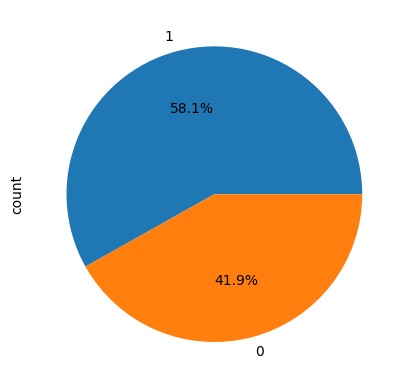

In [ ]:
df_train['CLASS'].value_counts().plot.pie(autopct='%1.1f%%')

In [ ]:
# Number of Comments for Each Video ID
df_train['VIDEO'].value_counts()

,count
VIDEO,
CevxZvSJLk8,314
9bZkp7q19f0,222
pRpeEdMmmQ0,200
KQ6zr6kCPj8,62


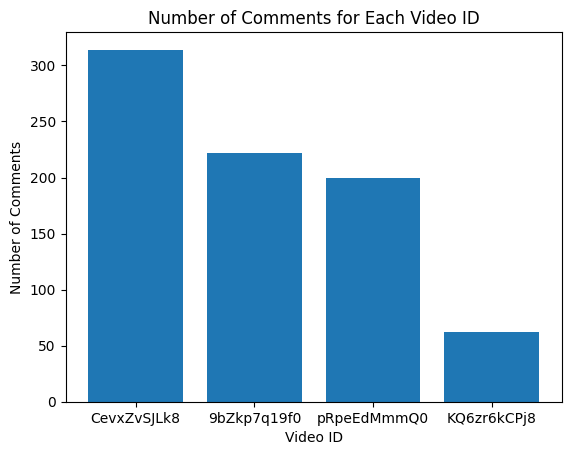

In [ ]:
plt.bar(df_train['VIDEO'].value_counts().index.tolist(), df_train['VIDEO'].value_counts().tolist())
plt.xlabel('Video ID')
plt.ylabel('Number of Comments')
plt.title('Number of Comments for Each Video ID')
plt.show()

In [ ]:
# Number of Comments for Each Video ID, Grouped By Class
video_0 = df_train.loc[df_train['CLASS'] == 0, 'VIDEO'].value_counts()
video_0

,count
VIDEO,
CevxZvSJLk8,158
9bZkp7q19f0,92
pRpeEdMmmQ0,67
KQ6zr6kCPj8,17


In [ ]:
video_1 = df_train.loc[df_train['CLASS'] == 1, 'VIDEO'].value_counts()
video_1

,count
VIDEO,
CevxZvSJLk8,156
pRpeEdMmmQ0,133
9bZkp7q19f0,130
KQ6zr6kCPj8,45


In [ ]:
count_video = pd.DataFrame({'0': video_0, '1': video_1}).sort_values(by=['1'], ascending=False)
count_video

,0,1
VIDEO,,
CevxZvSJLk8,158,156
pRpeEdMmmQ0,67,133
9bZkp7q19f0,92,130
KQ6zr6kCPj8,17,45


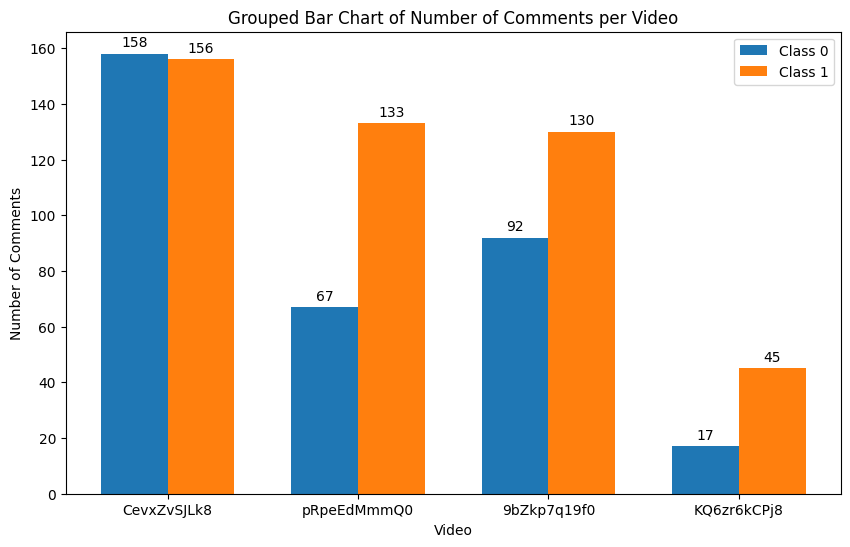

In [ ]:
x = np.arange(len(count_video))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

im1 = ax.bar(x-width/2, count_video['0'], width, label = 'Class 0')
im2 = ax.bar(x+width/2, count_video['1'], width, label = 'Class 1')

ax.set_xlabel('Video')
ax.set_ylabel('Number of Comments')
ax.set_title('Grouped Bar Chart of Number of Comments per Video')
ax.set_xticks(x)
ax.set_xticklabels(count_video.index)
ax.legend()

def autolabel(ims):
    for im in ims:
        height = im.get_height()
        ax.annotate(f'{height}',
                    xy=(im.get_x() + im.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(im1)
autolabel(im2)

plt.show()

In [ ]:
# Top 10 Authors with Highest Number of Comments
df_train['AUTHOR'].value_counts().sort_values(ascending=False)[:10]

,count
AUTHOR,
5000palo,7
Shadrach Grentz,7
LuckyMusiqLive,5
Hidden Love,5
James Cook,4
OFFICIAL LEXIS,3
ThirdDegr3e,3
macgyver16,3
ricky swaggz,3


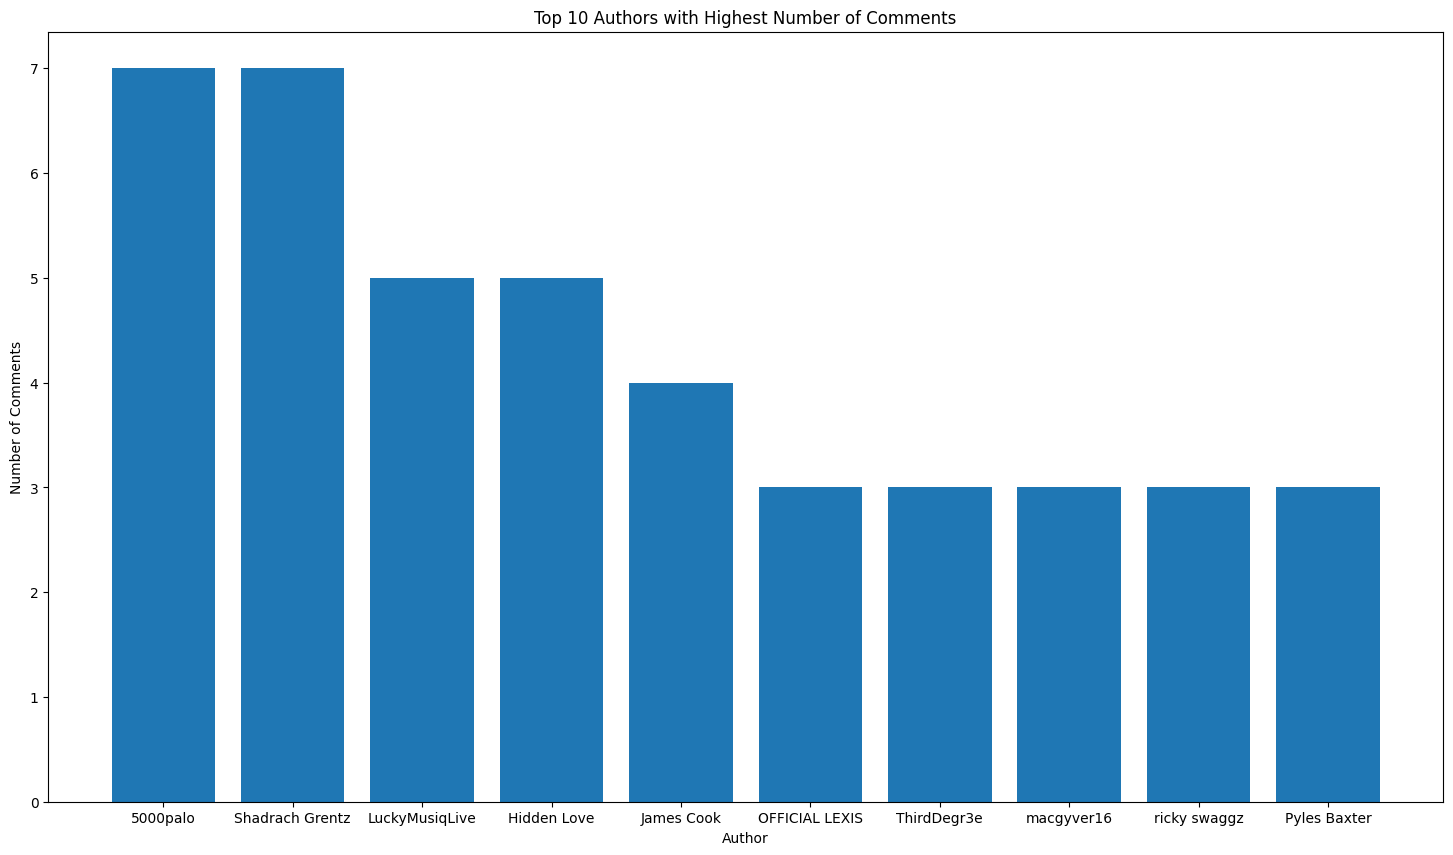

In [ ]:
plt.figure(figsize=(18, 10))
plt.bar(df_train['AUTHOR'].value_counts().sort_values(ascending=False)[:10].index.tolist(), df_train['AUTHOR'].value_counts().sort_values(ascending=False)[:10].tolist())
plt.xlabel('Author')
plt.ylabel('Number of Comments')
plt.title('Top 10 Authors with Highest Number of Comments')
plt.show()

In [ ]:
# list of authors' number of comments
author_all = df_train['AUTHOR'].value_counts()
author_all

,count
AUTHOR,
5000palo,7
Shadrach Grentz,7
LuckyMusiqLive,5
Hidden Love,5
James Cook,4
...,...
Evin Alshamas,1
Nossnevs SWEDEN,1
maddog1431,1


In [ ]:
# Class 0
author_0 = df_train.loc[df_train['CLASS'] == 0, 'AUTHOR'].value_counts()
author_0

,count
AUTHOR,
5000palo,7
tyler sleetway,2
The Technology Zoo,2
Alain Bruno,2
Naga Berapi,2
...,...
xhonavsky,1
Jack El Matador,1
Justin Chery,1


In [ ]:
# Top 10 Authors with Highest Number of Comments (Class 1)
author_1 = df_train.loc[df_train['CLASS'] == 1, 'AUTHOR'].value_counts()
author_1

,count
AUTHOR,
Shadrach Grentz,7
LuckyMusiqLive,5
Hidden Love,5
James Cook,4
Louis Bryant,3
...,...
xXxPWND 420xXx,1
BaconBro HD,1
Jdidk Loma,1


In [ ]:
count_author = pd.DataFrame({'0': author_0, '1': author_1}).sort_values(by=['1'], ascending=False).fillna(0)
count_author['0'] = count_author['0'].apply(lambda i: int(i))
count_author['1'] = count_author['1'].apply(lambda i: int(i))
count_author

,0,1
AUTHOR,,
Shadrach Grentz,0,7
LuckyMusiqLive,0,5
Hidden Love,0,5
James Cook,0,4
Pyles Baxter,0,3
...,...,...
ΑΓΛΑΪΑ ΛΕΠΤΟΚΑΡΙΔΟΥ,1,0
Λυδία Γκ,1,0
اسيا الخواجة,1,0


In [ ]:
count_author.sort_values(by='0', ascending=False)

,0,1
AUTHOR,,
5000palo,7,0
Alain Bruno,2,0
tyler sleetway,2,0
Juan Martinez,2,0
Chris Madzier,2,0
...,...,...
TopMusicWorld HD,0,1
Truc Ng,0,1
Tyrek Sings,0,1


In [ ]:
count_author.sort_values(by='1', ascending=False)

,0,1
AUTHOR,,
Shadrach Grentz,0,7
Hidden Love,0,5
LuckyMusiqLive,0,5
James Cook,0,4
roflcopter2110,0,3
...,...,...
"thevlogmasters Vlog, Challenges en nog veel meer!",1,0
t tatsuya,1,0
subscrool,1,0


In [ ]:
count_author[(count_author['0']!=0) & (count_author['1']!=0)]

,0,1
AUTHOR,,


Each author has tendency to consistent in one class (either give all spam messages or not)

In [ ]:
# top comments flow based on the date
df_train['date_info'].value_counts().sort_values(ascending=False)[:10]

,count
date_info,
2014-11-07,52
2014-11-06,45
2014-11-05,36
2014-01-20,21
2014-11-04,21
2013-10-04,17
2014-07-22,16
2014-11-02,16
2013-10-02,15


## Text Visualization

### Frequence of Text and Words

In [ ]:
df_train.columns

Index(['VIDEO', 'AUTHOR', 'DATE', 'TEXT', 'CLASS', 'date_info', 'time'], dtype='object')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   VIDEO      798 non-null    object         
 1   AUTHOR     798 non-null    object         
 2   DATE       798 non-null    object         
 3   TEXT       798 non-null    object         
 4   CLASS      798 non-null    int64          
 5   date_info  798 non-null    datetime64[ns] 
 6   time       798 non-null    timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(4), timedelta64[ns](1)
memory usage: 43.8+ KB


In [ ]:
# The Frequency of Top 10 Comments
df_train['TEXT'].value_counts().sort_values(ascending=False)[:10]

,count
TEXT,
Check out this video on YouTube:﻿,7
Shakira :-*,4
"Hey Music Fans I really appreciate any of you who will take the time to read this, and check my music out! I&#39;m just a 15 year old boy DREAMING of being a successful MUSICIAN in the music world. I do lots of covers, and piano covers. But I don&#39;t have money to advertise. A simple thumbs up to my comment, a comment on my videos or a SUBSCRIPTION would be a step forward! It will only be a few seconds of your life that you won&#39;t regret!!! Thank u to all the people who just give me a chance! :)",4
Hi. Check out and share our songs.,4
Katy Perry - Roar (Official): http://youtu.be/CevxZvSJLk8﻿,3
"Hello Guys...I Found a Way to Make Money Online You Can Get Paid To Mess Around On Facebook And Twitter! GET PAID UPTO $25 to $35 AN HOUR...Only at 4NetJobs.com Work from the Comfort of your Home... They are Currently Hiring People from all Over the World, For a Wide Range of Social Media Jobs on Sites such as Facebook,Twitter and YouTube You don&#39;t Need any Prior Skills or Experience and You can Begin Work Immediately! You Can Easily Make $4000 to $5000+ Monthly Income…Only at 4NetJobs.com",3
wow,3
**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE****,3
"Hello everyone :) I know most of you probably pass up these kind of comments, but for those who are still reading this, thanks! I don’t have any money for advertisements, no chance of getting heard, nothing. I live in such a small town... If this comes off as spam, sorry. I’m an instrumental songwriter from Columbus, Mississippi. Please go to my channel and check out my original music. It would be highly appreciated if you thumbs up this comment so my music can be heard! Thank you, Adam Whitney",3


In [ ]:
# word cloud (without much text processing) in spam class
punctuations = string.punctuation

sp = spacy.load("en_core_web_sm")
stop_words = sp.Defaults.stop_words

def preprocess1(text):
  doc = sp(text)
  tokenize = [word.lemma_.lower().strip() for word in doc]
  result = [word for word in tokenize if word not in stop_words and word not in punctuations]
  return result

In [ ]:
spam = pd.DataFrame(df_train[df_train['CLASS']==1]['TEXT'])
spam['TEXT'] = spam['TEXT'].apply(lambda i: preprocess1(i))
spam

,TEXT
8,"[check, new, mixtape, check, new, mixtape, che..."
9,"[check, new, mixtape, check, new, mixtape, che..."
10,"[check, new, mixtape, check, new, mixtape, che..."
11,"[hey, music, fans, appreciate, time, read, che..."
12,"[omg, facebook, old, check, -----------------&..."
...,...
784,"[friend, read, book, repass, http://www.4share..."
785,"[subscribe, :), ﻿]"
788,"[nowplaye, weekendmix, track, 04, katy, perry,..."
790,"[hello, kind, new, youtube, soon, soon, launch..."


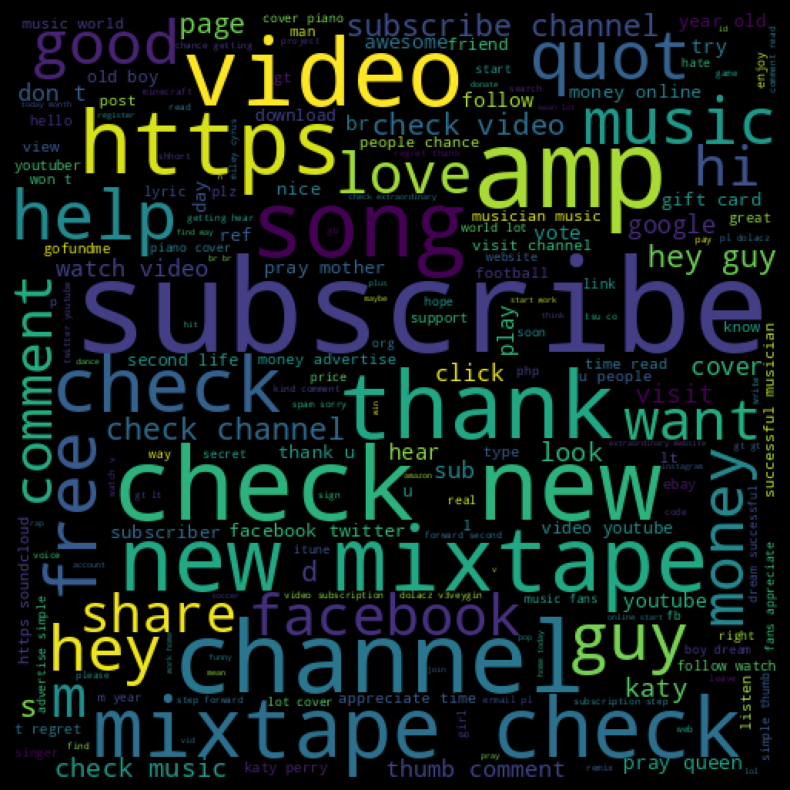

In [ ]:
spam_wc = WordCloud(width=500, height=500).generate(' '.join([i for j in spam['TEXT'] for i in j]))
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_wc)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
spam_freq = spam_wc.words_
sorted(spam_freq.items(), key=lambda x: x[1], reverse=True)[:10]

[('subscribe', 1.0),
 ('amp', 0.696969696969697),
 ('check new', 0.5959595959595959),
 ('channel', 0.5656565656565656),
 ('video', 0.5151515151515151),
 ('thank', 0.494949494949495),
 ('song', 0.48484848484848486),
 ('new mixtape', 0.48484848484848486),
 ('https', 0.47474747474747475),
 ('mixtape check', 0.47474747474747475)]

In [ ]:
# word cloud (without much text processing) in non-spam class
non_spam = pd.DataFrame(df_train[df_train['CLASS']==0]['TEXT'])
non_spam['TEXT'] = non_spam['TEXT'].apply(lambda i: preprocess1(i))
non_spam

,TEXT
0,"[shakira, good, dancer]"
1,"[shakira, u, wiredo]"
2,[wow]
3,"[love, song, reason, 1.it, africa, 2.i, bear, ..."
4,"[love, song, sing, camp, time]"
...,...
792,"[2, billion, view, piece, shit, ..., r, e, y, ..."
793,"[gangman, sty-, d, d, d, d, d, d, --, drop, ba..."
794,"[song, reach, 7, billion, views?﻿]"
796,"[katy, perry, song, good, song, woman, artists.﻿]"


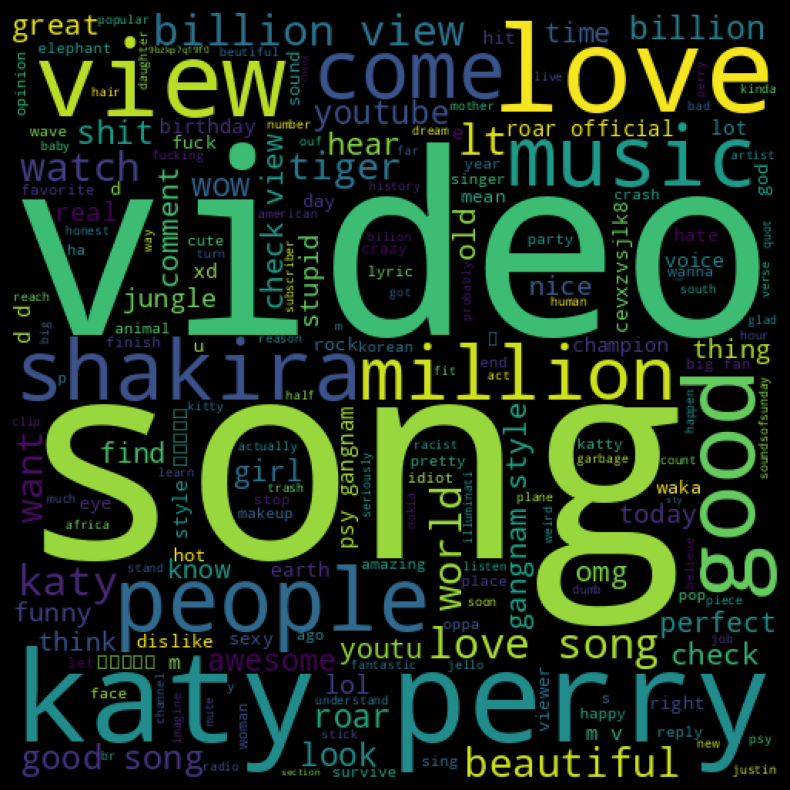

In [ ]:
nonspam_wc = WordCloud(width=500, height=500).generate(' '.join([i for j in non_spam['TEXT'] for i in j]))
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(nonspam_wc)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
nonspam_freq = nonspam_wc.words_
sorted(nonspam_freq.items(), key=lambda x: x[1], reverse=True)[:10]

[('song', 1.0),
 ('video', 1.0),
 ('katy perry', 0.7755102040816326),
 ('love', 0.673469387755102),
 ('view', 0.5102040816326531),
 ('good', 0.42857142857142855),
 ('people', 0.3469387755102041),
 ('shakira', 0.32653061224489793),
 ('music', 0.32653061224489793),
 ('come', 0.30612244897959184)]

In [ ]:
# stop word
df_train['stopWord'] = df_train['TEXT'].apply(lambda i: len([j for j in str(i).lower().split() if j in stop_words]))
df_train.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,stopWord
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000,2
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000,2
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000,0
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000,8
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000,8


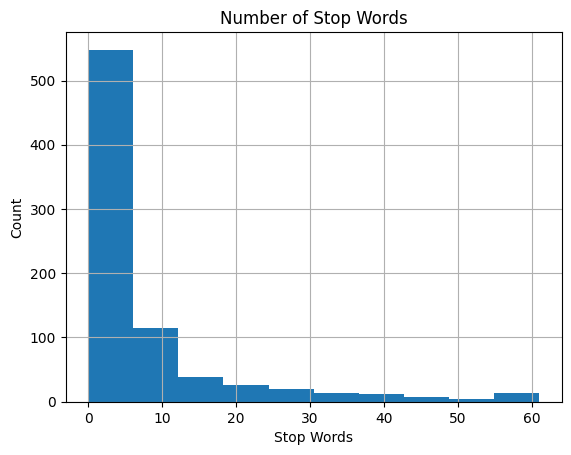

In [ ]:
df_train['stopWord'].hist()

plt.xlabel('Stop Words')
plt.ylabel('Count')
plt.title('Number of Stop Words')
plt.show()

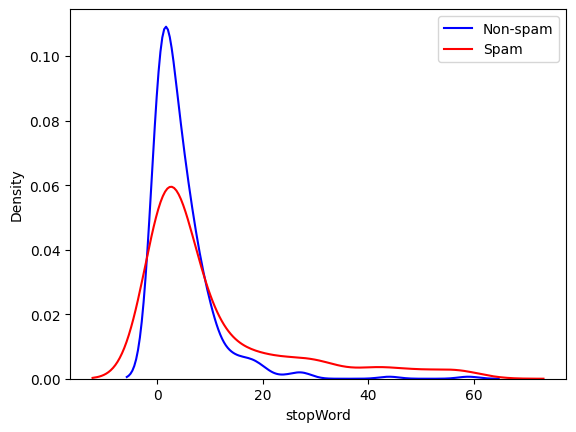

In [ ]:
sns.kdeplot(df_train[df_train['CLASS']==0]['stopWord'], color='b')
sns.kdeplot(df_train[df_train['CLASS']==1]['stopWord'], color='r')
plt.legend(['Non-spam', 'Spam'])

# Text Preprocessing & Feature Selection

## Text Preprocessing

In [22]:
punctuations = string.punctuation
print(punctuations)

sp = spacy.load("en_core_web_sm")
stop_words = sp.Defaults.stop_words
add_sw = {"omg", 'lol'}
stop_words.update(add_sw)
print(stop_words)

english_words = set(words.words())

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
{'ever', 'forty', 'a', 'omg', 'these', 'on', 'thereafter', 'eleven', 'can', 'under', 'own', 'less', 'between', 'too', 'they', 'sixty', 'where', 'again', 'eight', 'does', 'everything', 'over', "'s", 'even', 'further', 'because', 'please', 'across', 'in', 'made', 'did', 'via', 'show', 'see', 'per', "'m", 'an', 'became', 'the', 'afterwards', 'who', 'you', 'about', 'somewhere', 'thereby', 'formerly', 'toward', 'also', 'serious', 'yourselves', 'another', 'nevertheless', 'then', 'all', 'yours', 'whole', 'or', 'his', '’s', 'bottom', 'therefore', 'ca', 'have', 'name', 'throughout', 'be', 'almost', 'since', 'herein', 're', '’re', 'every', 'few', 'whereupon', 'himself', 'anyone', 'us', 'being', 'neither', 'there', 'to', '‘ve', '‘ll', 'enough', 'around', 'becoming', 'has', 'least', 'she', 'former', 'which', 'so', 'what', 'thru', 'within', 'mine', 'three', 'through', 'no', 'ten', 'last', 'alone', 'everywhere', 'really', 'why', 'would', 'should', 'done', 'herself', 

In [23]:
def preprocess_all(text):
  text = emoji.demojize(text)
  # remove special characters
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s+', ' ', text)

  # remove repeated characters
  text = re.sub(r'(.)\1+', r'\1', text)

  doc = sp(text)
  tokenize = [word.lemma_.lower().strip() for word in doc]
  result = [word for word in tokenize if word not in stop_words and word not in punctuations]
  result = [word for word in result if len(word)>1]
  return result

df_train['pre_text'] = df_train['TEXT'].apply(lambda i: preprocess_all(i))
df_test['pre_text'] = df_test['TEXT'].apply(lambda i: preprocess_all(i))
df_train.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,pre_text
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000,"[shakira, good, dancer]"
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000,"[shakira, wiredo]"
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000,[wow]
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000,"[love, song, reason, africa, bear, beautiful, ..."
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000,"[love, song, sing, camp, al, time]"


In [24]:
df_train.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,pre_text
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000,"[shakira, good, dancer]"
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000,"[shakira, wiredo]"
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000,[wow]
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000,"[love, song, reason, africa, bear, beautiful, ..."
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000,"[love, song, sing, camp, al, time]"


## Word and Characters Visualization

In [ ]:
# word length
df_train['word_length'] = df_train['pre_text'].apply(lambda i: len(i))
df_train.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,pre_text,word_length
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000,"[shakira, good, dancer]",3
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000,"[shakira, wiredo]",2
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000,[wow],1
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000,"[love, song, reason, africa, bear, beautiful, ...",8
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000,"[love, song, sing, camp, al, time]",6


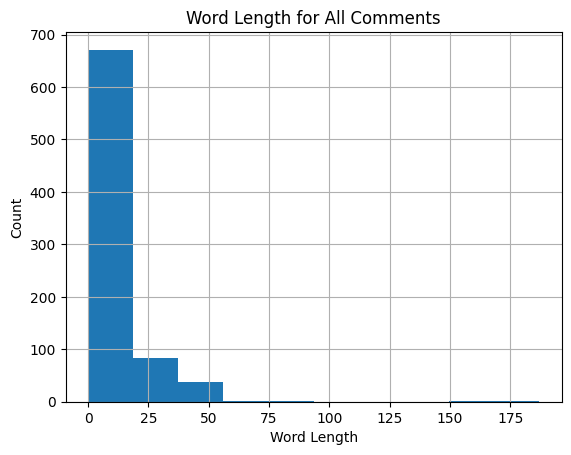

In [ ]:
df_train['word_length'].hist()
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.title('Word Length for All Comments')
plt.show()

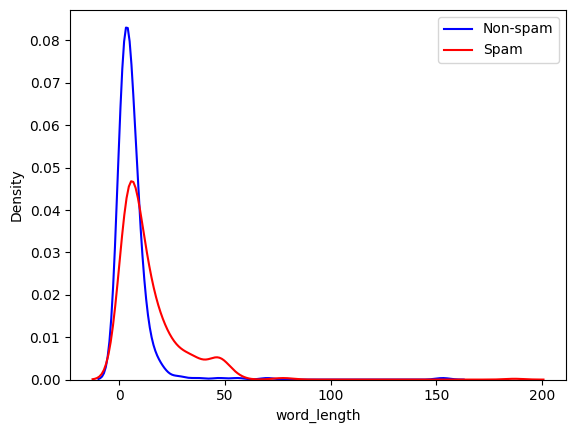

In [ ]:
sns.kdeplot(df_train[df_train['CLASS']==0]['word_length'], color='b')
sns.kdeplot(df_train[df_train['CLASS']==1]['word_length'], color='r')
plt.legend(['Non-spam', 'Spam'])
plt.show()

In [ ]:
# character length
# number of characters
df_train['char_length'] = df_train['pre_text'].apply(lambda i: sum(len(j) for j in i))
df_train.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,pre_text,word_length,char_length
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000,"[shakira, good, dancer]",3,17
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000,"[shakira, wiredo]",2,13
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000,[wow],1,3
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000,"[love, song, reason, africa, bear, beautiful, ...",8,44
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000,"[love, song, sing, camp, al, time]",6,22


<ipython-input-280-27e36fcb957e>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


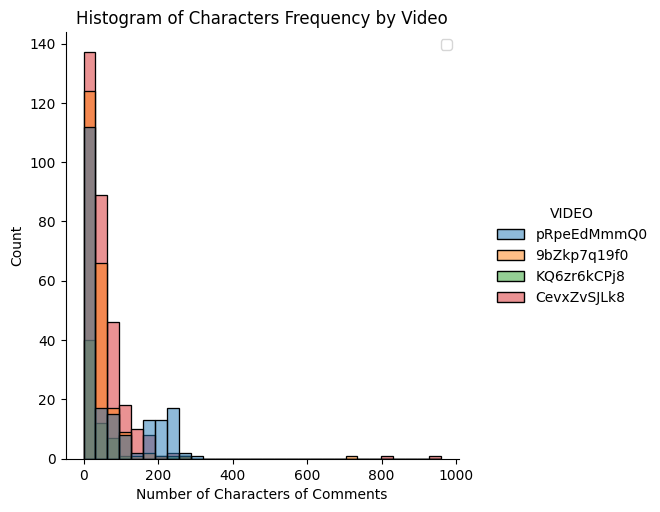

In [ ]:
sns.displot(data=df_train, x='char_length', hue='VIDEO', bins=30, multiple='layer', kde=False)

plt.xlabel('Number of Characters of Comments')
plt.ylabel('Count')
plt.title('Histogram of Characters Frequency by Video')
plt.legend()
plt.show()

<ipython-input-281-0676285da262>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


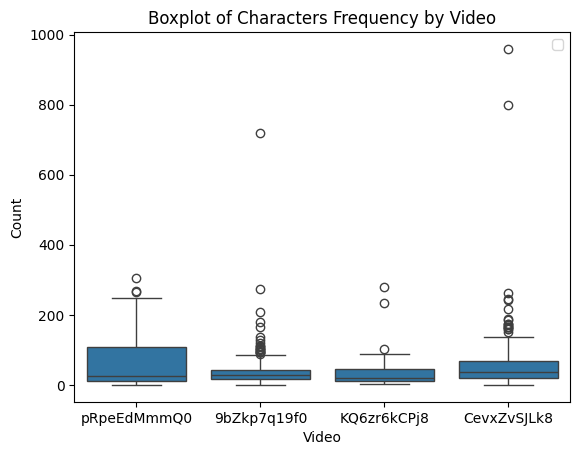

In [ ]:
sns.boxplot(data=df_train, x='VIDEO', y='char_length')

plt.xlabel('Video')
plt.ylabel('Count')
plt.title('Boxplot of Characters Frequency by Video')
plt.legend()
plt.show()

<ipython-input-282-df04cc894f5e>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


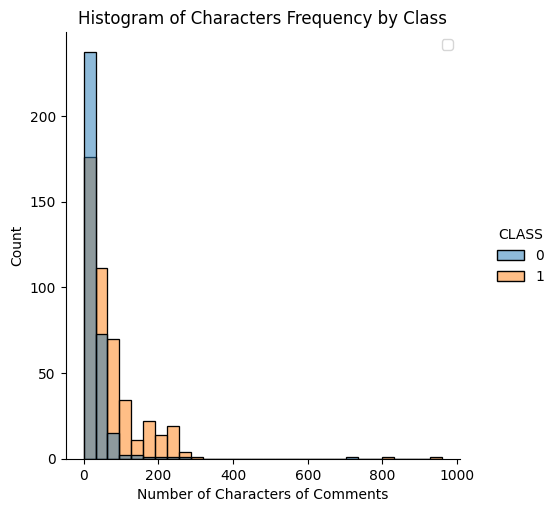

In [ ]:
df_train['CLASS'] = df_train['CLASS'].astype('category')
sns.displot(data=df_train, x='char_length', hue='CLASS', bins=30, multiple='layer', kde=False)

plt.xlabel('Number of Characters of Comments')
plt.ylabel('Count')
plt.title('Histogram of Characters Frequency by Class')
plt.legend()
plt.show()

<Axes: xlabel='char_length', ylabel='word_length'>

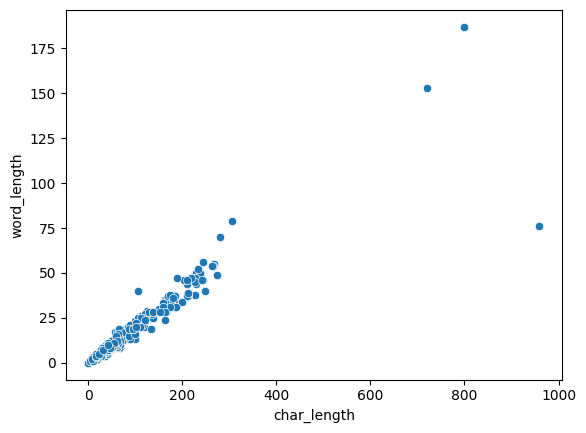

In [ ]:
sns.scatterplot(data=df_train, x='char_length', y='word_length')

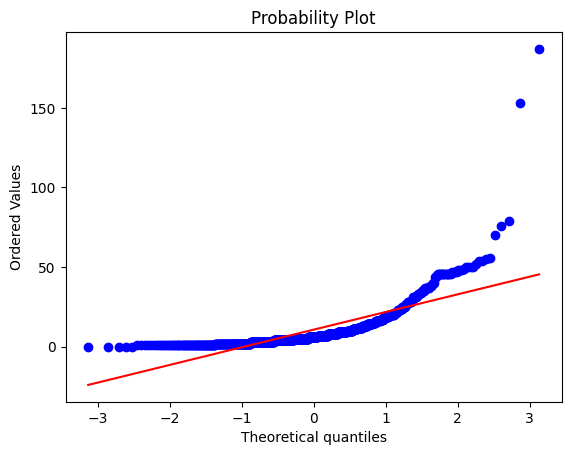

In [ ]:
stats.probplot(df_train['word_length'], plot=plt)
plt.show()

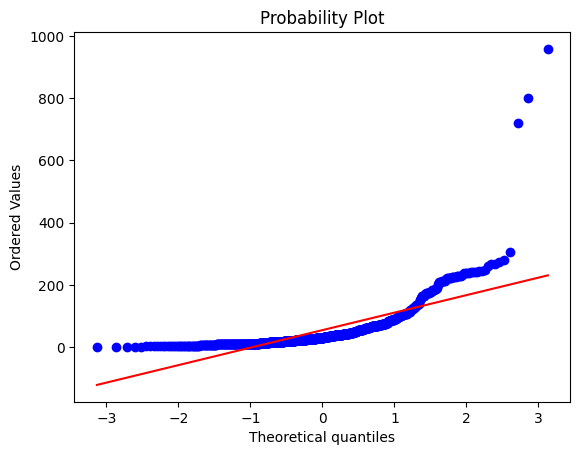

In [ ]:
stats.probplot(df_train['char_length'], plot=plt)
plt.show()

In [ ]:
df_train.columns

Index(['VIDEO', 'AUTHOR', 'DATE', 'TEXT', 'CLASS', 'date_info', 'time',
       'pre_text', 'word_length', 'char_length'],
      dtype='object')

In [ ]:
# unique words
df_train['len_unique_word'] = df_train['pre_text'].apply(lambda i: len(set(i)))
df_train.head(10)

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,pre_text,word_length,char_length,len_unique_word
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000,"[shakira, good, dancer]",3,17,3
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000,"[shakira, wiredo]",2,13,2
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000,[wow],1,3,1
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000,"[love, song, reason, africa, bear, beautiful, ...",8,44,7
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000,"[love, song, sing, camp, al, time]",6,22,6
5,pRpeEdMmmQ0,Dinova Sharon,2013-07-13T14:44:00.700000,well done shakira,0,2013-07-13,0 days 14:44:00.700000,"[wel, shakira]",2,10,2
6,pRpeEdMmmQ0,TheHotChocolate,2013-07-13T18:26:37.017000,she is sooooo beautiful!,0,2013-07-13,0 days 18:26:37.017000,[beautiful],1,9,1
7,pRpeEdMmmQ0,Ysobel Schofield,2013-07-13T20:17:25.181000,Waka waka she rules,0,2013-07-13,0 days 20:17:25.181000,"[waka, waka, rule]",3,12,2
8,pRpeEdMmmQ0,ThirdDegr3e,2013-07-13T20:47:40.793000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1,2013-07-13,0 days 20:47:40.793000,"[check, new, mixtape, check, new, mixtape, che...",48,240,3
9,pRpeEdMmmQ0,ThirdDegr3e,2013-07-13T20:48:06.033000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1,2013-07-13,0 days 20:48:06.033000,"[check, new, mixtape, check, new, mixtape, che...",48,240,3


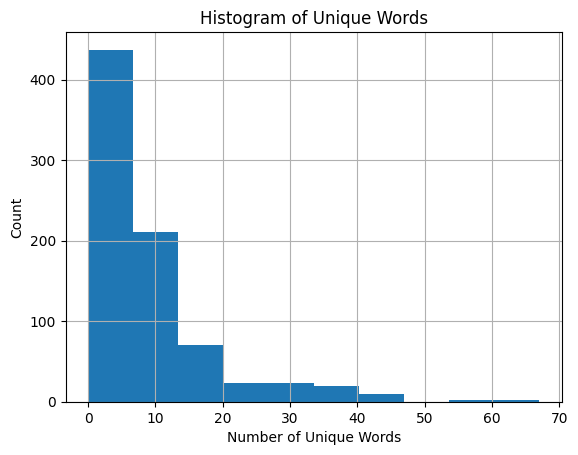

In [ ]:
df_train['len_unique_word'].hist()
plt.xlabel('Number of Unique Words')
plt.ylabel('Count')
plt.title('Histogram of Unique Words')
plt.show()

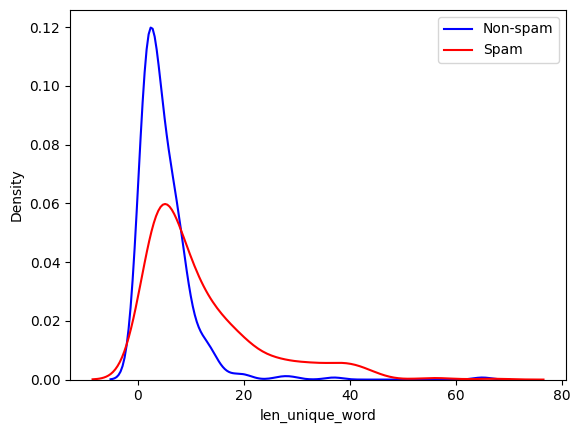

In [ ]:
sns.kdeplot(df_train[df_train['CLASS']==0]['len_unique_word'], color='b')
sns.kdeplot(df_train[df_train['CLASS']==1]['len_unique_word'], color='r')
plt.legend(['Non-spam', 'Spam'])
plt.show()

<Axes: xlabel='char_length', ylabel='len_unique_word'>

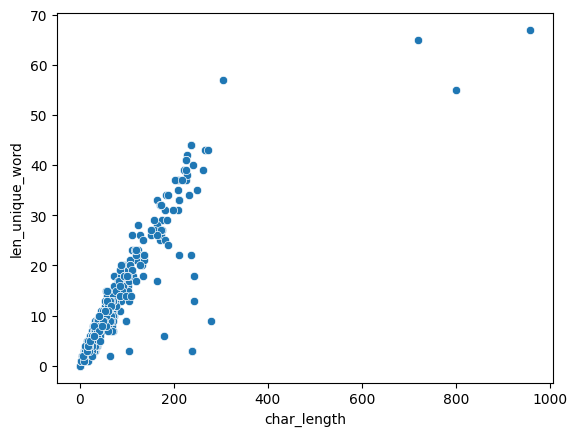

In [ ]:
sns.scatterplot(data=df_train, x='char_length', y='len_unique_word')

<Axes: xlabel='word_length', ylabel='len_unique_word'>

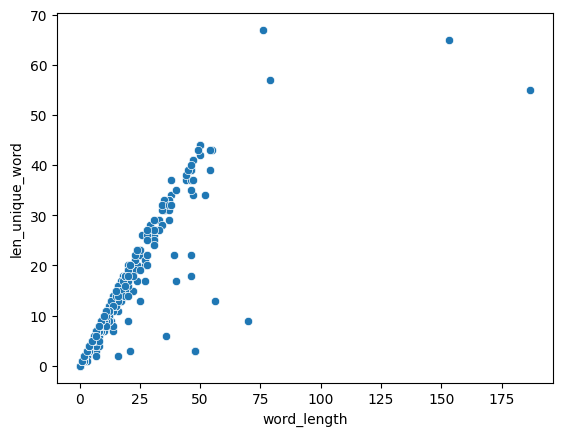

In [ ]:
sns.scatterplot(data=df_train, x='word_length', y='len_unique_word')

## Feature Selection

###Train data

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   VIDEO      798 non-null    object         
 1   AUTHOR     798 non-null    object         
 2   DATE       798 non-null    object         
 3   TEXT       798 non-null    object         
 4   CLASS      798 non-null    int64          
 5   date_info  798 non-null    datetime64[ns] 
 6   time       798 non-null    timedelta64[ns]
 7   pre_text   798 non-null    object         
dtypes: datetime64[ns](1), int64(1), object(5), timedelta64[ns](1)
memory usage: 50.0+ KB


In [26]:
df_train['all_message'] = df_train['pre_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df_train.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,pre_text,all_message
0,pRpeEdMmmQ0,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0,2013-07-12,0 days 22:33:27.916000,"[shakira, good, dancer]",shakira good dancer
1,pRpeEdMmmQ0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,2013-07-13,0 days 11:17:52.308000,"[shakira, wiredo]",shakira wiredo
2,pRpeEdMmmQ0,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,2013-07-13,0 days 12:09:31.188000,[wow],wow
3,pRpeEdMmmQ0,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,2013-07-13,0 days 13:14:30.021000,"[love, song, reason, africa, bear, beautiful, ...",love song reason africa bear beautiful south a...
4,pRpeEdMmmQ0,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,2013-07-13,0 days 13:27:39.441000,"[love, song, sing, camp, al, time]",love song sing camp al time


In [27]:
from sklearn.preprocessing import OneHotEncoder
author_encoder = OneHotEncoder(handle_unknown='ignore')
video_encoder = OneHotEncoder(handle_unknown='ignore')
X_author = author_encoder.fit_transform(df_train[['AUTHOR']])
X_video = video_encoder.fit_transform(df_train[['VIDEO']])

In [28]:
# using tf-idf
tfIdf_vec = TfidfVectorizer()
x = tfIdf_vec.fit_transform(df_train['all_message'])

In [29]:
from scipy.sparse import hstack
X_combined = hstack([x, X_author, X_video])

### Test data

In [30]:
df_test['all_message'] = df_test['pre_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df_test.head()

,VIDEO,AUTHOR,DATE,TEXT,CLASS,date_info,time,pre_text,all_message
0,9bZkp7q19f0,Adele Lupei,2014-11-07T19:47:06,"Is this the video that started the whole ""got ...",0,2014-11-07,0 days 19:47:06,"[video, start, dick, stick, elevator, excuse, ...",video start dick stick elevator excuse thing
1,9bZkp7q19f0,Daniel Istrati,2014-11-07T19:47:16,Can anyone sub to my channel? :Dï»¿,1,2014-11-07,0 days 19:47:16,"[sub, chanel]",sub chanel
2,9bZkp7q19f0,Stronzo Chicheritr,2014-11-07T20:01:15,prehistoric song..has beenï»¿,0,2014-11-07,0 days 20:01:15,"[prehistoric, song, ben]",prehistoric song ben
3,9bZkp7q19f0,none dies virgin life fucks us all,2014-11-07T20:05:35,You think you're smart? Headbutt your f...,0,2014-11-07,0 days 20:05:35,"[think, smart, headbut, face]",think smart headbut face
4,9bZkp7q19f0,JakeFrostMiner Palanca,2014-11-07T20:12:11,DISLIKE.. Now one knows REAL music - ex. Enime...,0,2014-11-07,0 days 20:12:11,"[dislike, know, real, music, ex, eniman]",dislike know real music ex eniman


In [31]:
X_author_test = author_encoder.transform(df_test[['AUTHOR']])
X_video_test = video_encoder.transform(df_test[['VIDEO']])

# using tf-idf
X_test = tfIdf_vec.transform(df_test['all_message'])
X_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1110 stored elements and shape (202, 2383)>

In [32]:
x_test = hstack([X_test, X_author_test, X_video_test])
x_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1314 stored elements and shape (202, 3121)>

# Classification

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
from sklearn import metrics
import math
from sklearn.linear_model import LogisticRegressionCV
import time
from sklearn.model_selection import RandomizedSearchCV

In [34]:
x_train, x_val, y_train, y_val = train_test_split(X_combined, df_train['CLASS'], test_size=0.3, random_state=42)
print(f"Train features shape: {x_train.shape}")
print(f"Validation features shape: {x_val.shape}")
print(f"Train label shape: {y_train.shape}")
print(f"Validation label shape: {y_val.shape}")

Train features shape: (558, 3121)
Validation features shape: (240, 3121)
Train label shape: (558,)
Validation label shape: (240,)


In [35]:
y_test = df_test['CLASS']
# y_test

In [36]:
def metrics_eval(y_val, y_pred):
  acc = accuracy_score(y_val, y_pred)
  prec = precision_score(y_val, y_pred)
  rec = recall_score(y_val, y_pred)
  f1Score = f1_score(y_val, y_pred)
  auc_roc = roc_auc_score(y_val, y_pred)
  confusion = confusion_matrix(y_val, y_pred)
  tn, fp, fn, tp = confusion.ravel()
  specificity = tn / (tn+fp)
  NPV = tn / (tn+fn)

  print(f"Accuracy: {acc}")
  print(f"Precision: {prec}")
  print(f"Recall: {rec}")
  print(f"f1-score: {f1Score}")
  print(f"NPV: {NPV}")
  print(f"Specificity: {specificity}")
  return acc, prec, rec, f1Score, NPV, specificity

In [37]:
def conf_mat(data):
  plt.figure(figsize=(6, 4))
  sns.heatmap(data, annot=True, cbar=False, fmt='d')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

In [38]:
def class_rep(y_val, y_pred):
  cr = metrics.classification_report(y_val, y_pred, output_dict=True)
  nb_report=pd.DataFrame(cr).transpose()
  print(nb_report)

In [39]:
model_Performance={}

In [40]:
model_trainTime = {}
model_ht_trainTime = {}

## Naive Bayes

In [41]:
nb = MultinomialNB()
start_time = time.perf_counter()
nb_model = nb.fit(x_train, y_train)
training_time = time.perf_counter() - start_time
model_trainTime['Naive_Bayes'] = training_time
print(f"Training time: {model_trainTime['Naive_Bayes']:.4f} seconds")

y_pred = nb.predict(x_val)

Training time: 0.0092 seconds


In [42]:
class_rep(y_val, y_pred)

              precision    recall  f1-score     support
0              0.912088  0.821782  0.864583  101.000000
1              0.879195  0.942446  0.909722  139.000000
accuracy       0.891667  0.891667  0.891667    0.891667
macro avg      0.895641  0.882114  0.887153  240.000000
weighted avg   0.893037  0.891667  0.890726  240.000000


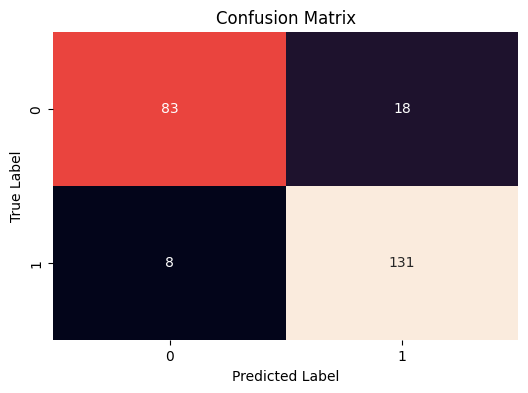

In [43]:
nb_cm = metrics.confusion_matrix(y_val, y_pred)
conf_mat(nb_cm)

In [44]:
metrics_eval(y_val, y_pred)

Accuracy: 0.8916666666666667
Precision: 0.8791946308724832
Recall: 0.9424460431654677
f1-score: 0.9097222222222222
NPV: 0.9120879120879121
Specificity: 0.8217821782178217


(0.8916666666666667,
 0.8791946308724832,
 0.9424460431654677,
 0.9097222222222222,
 np.float64(0.9120879120879121),
 np.float64(0.8217821782178217))

In [45]:
# testing
y_test_pred = nb.predict(x_test)

class_rep(y_test, y_test_pred)

              precision    recall  f1-score     support
0              1.000000  0.500000  0.666667   92.000000
1              0.705128  1.000000  0.827068  110.000000
accuracy       0.772277  0.772277  0.772277    0.772277
macro avg      0.852564  0.750000  0.746867  202.000000
weighted avg   0.839426  0.772277  0.754014  202.000000


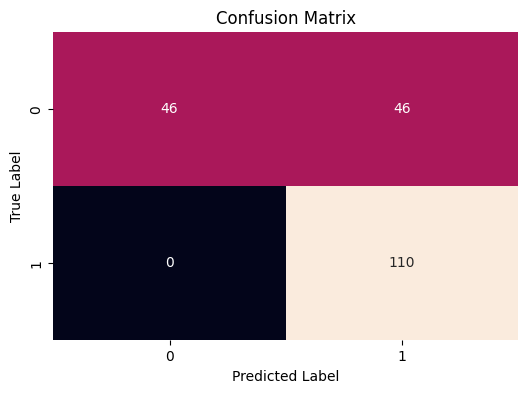

In [46]:
nb_cm_test = metrics.confusion_matrix(y_test, y_test_pred)
conf_mat(nb_cm_test)

In [47]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, y_test_pred)

Accuracy: 0.7722772277227723
Precision: 0.7051282051282052
Recall: 1.0
f1-score: 0.8270676691729323
NPV: 1.0
Specificity: 0.5


In [48]:
model_Performance['Naive Bayes']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['Naive Bayes']

[0.7722772277227723,
 0.7051282051282052,
 1.0,
 0.8270676691729323,
 np.float64(1.0),
 np.float64(0.5)]

## Naive Bayes (Adjust Parameter)

In [49]:
param_dist = {
    'alpha': np.logspace(-3, 2, 100),
    'fit_prior': [True, False]
}

nb = MultinomialNB()

start_time = time.perf_counter()
nb_rs = RandomizedSearchCV(nb, param_dist, n_iter=20, cv=5, scoring='f1', random_state=42)
nb_model = nb_rs.fit(x_train, y_train)
training_time = time.perf_counter() - start_time
model_ht_trainTime['Naive_Bayes'] = training_time
print(f"Training time: {model_trainTime['Naive_Bayes']:.4f} seconds")

y_pred = nb_model.predict(x_val)

Training time: 0.0092 seconds


In [50]:
class_rep(y_val, y_pred)

              precision    recall  f1-score     support
0              0.855856  0.940594  0.896226  101.000000
1              0.953488  0.884892  0.917910  139.000000
accuracy       0.908333  0.908333  0.908333    0.908333
macro avg      0.904672  0.912743  0.907068  240.000000
weighted avg   0.912401  0.908333  0.908785  240.000000


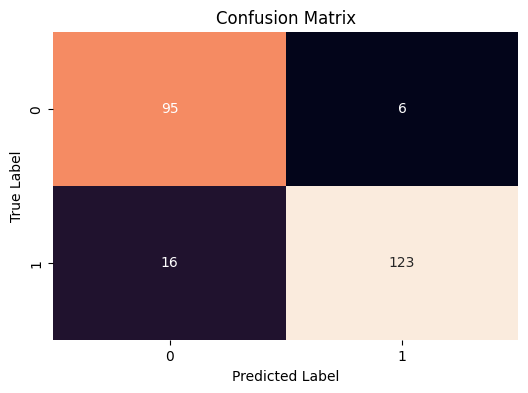

In [51]:
nb_cm = metrics.confusion_matrix(y_val, y_pred)
conf_mat(nb_cm)

In [52]:
metrics_eval(y_val, y_pred)

Accuracy: 0.9083333333333333
Precision: 0.9534883720930233
Recall: 0.8848920863309353
f1-score: 0.917910447761194
NPV: 0.8558558558558559
Specificity: 0.9405940594059405


(0.9083333333333333,
 0.9534883720930233,
 0.8848920863309353,
 0.917910447761194,
 np.float64(0.8558558558558559),
 np.float64(0.9405940594059405))

In [53]:
# testing
y_test_pred = nb_model.predict(x_test)

class_rep(y_test, y_test_pred)

              precision    recall  f1-score     support
0              0.957143  0.728261  0.827160   92.000000
1              0.810606  0.972727  0.884298  110.000000
accuracy       0.861386  0.861386  0.861386    0.861386
macro avg      0.883874  0.850494  0.855729  202.000000
weighted avg   0.877346  0.861386  0.858275  202.000000


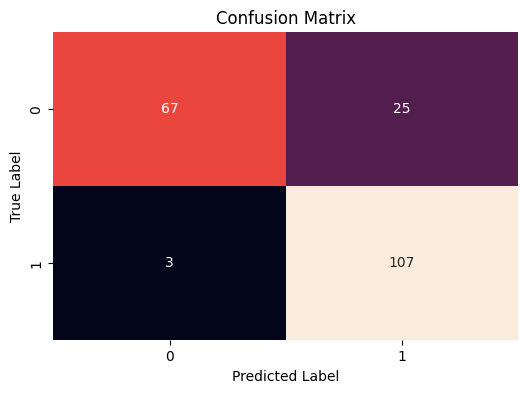

In [54]:
nb_cm_test = metrics.confusion_matrix(y_test, y_test_pred)
conf_mat(nb_cm_test)

In [55]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, y_test_pred)

Accuracy: 0.8613861386138614
Precision: 0.8106060606060606
Recall: 0.9727272727272728
f1-score: 0.8842975206611571
NPV: 0.9571428571428572
Specificity: 0.7282608695652174


In [56]:
model_Performance['Naive Bayes (Hyperparameter Tuning)']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['Naive Bayes (Hyperparameter Tuning)']

[0.8613861386138614,
 0.8106060606060606,
 0.9727272727272728,
 0.8842975206611571,
 np.float64(0.9571428571428572),
 np.float64(0.7282608695652174)]

## Logistic Regression

In [57]:
lr_model = LogisticRegression(random_state=42)
start_time = time.perf_counter()
lr_model.fit(x_train, y_train)
training_time = time.perf_counter() - start_time
model_trainTime['LR'] = training_time
y_pred_lr = lr_model.predict(x_val)

In [58]:
metrics_eval(y_val, y_pred_lr)

Accuracy: 0.9
Precision: 0.9020979020979021
Recall: 0.9280575539568345
f1-score: 0.9148936170212766
NPV: 0.8969072164948454
Specificity: 0.8613861386138614


(0.9,
 0.9020979020979021,
 0.9280575539568345,
 0.9148936170212766,
 np.float64(0.8969072164948454),
 np.float64(0.8613861386138614))

In [59]:
class_rep(y_val, y_pred_lr)

              precision    recall  f1-score  support
0              0.896907  0.861386  0.878788    101.0
1              0.902098  0.928058  0.914894    139.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.899503  0.894722  0.896841    240.0
weighted avg   0.899913  0.900000  0.899699    240.0


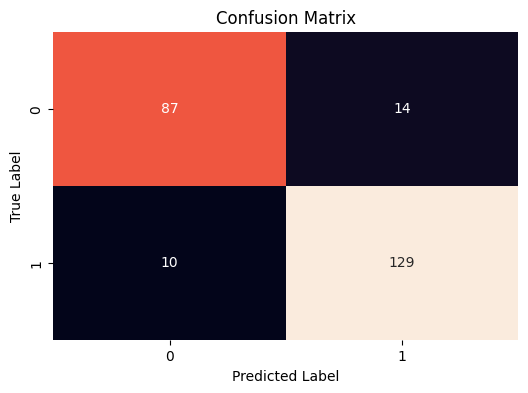

In [60]:
lr_cm = metrics.confusion_matrix(y_val, y_pred_lr)
conf_mat(lr_cm)

In [61]:
# testing
ylr_test_pred = lr_model.predict(x_test)
class_rep(y_test, ylr_test_pred)

              precision    recall  f1-score    support
0              0.973684  0.804348  0.880952   92.00000
1              0.857143  0.981818  0.915254  110.00000
accuracy       0.900990  0.900990  0.900990    0.90099
macro avg      0.915414  0.893083  0.898103  202.00000
weighted avg   0.910221  0.900990  0.899632  202.00000


In [62]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, ylr_test_pred)

Accuracy: 0.900990099009901
Precision: 0.8571428571428571
Recall: 0.9818181818181818
f1-score: 0.9152542372881356
NPV: 0.9736842105263158
Specificity: 0.8043478260869565


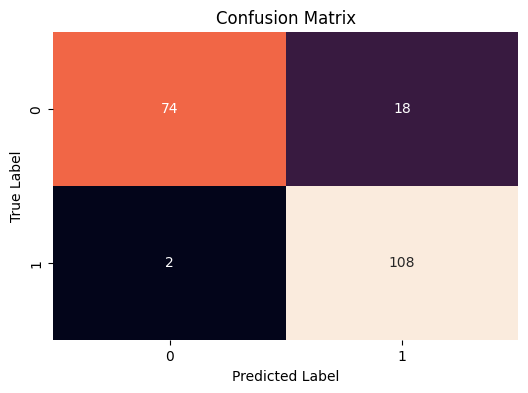

In [63]:
lr_cm_test = metrics.confusion_matrix(y_test, ylr_test_pred)
conf_mat(lr_cm_test)

In [64]:
model_Performance['Logistic Regression']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['Logistic Regression']

[0.900990099009901,
 0.8571428571428571,
 0.9818181818181818,
 0.9152542372881356,
 np.float64(0.9736842105263158),
 np.float64(0.8043478260869565)]

## Logistic Regression (Adjust Parameter)

In [65]:
lr_model1 = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(5, -6, -1))), cv=5, scoring='roc_auc', penalty='l2',
                           solver='newton-cg', max_iter=30000, random_state=42)
start_time = time.perf_counter()
lr_model1.fit(x_train, y_train)

print(f'AUC-ROC of Spam: {lr_model1.scores_[1].mean(axis=0)}')
print(f'The max AUC-ROC score: {lr_model1.scores_[1].mean(axis=0).max()}')

i = np.where(lr_model1.scores_[1].mean(axis=0)==lr_model1.scores_[1].mean(axis=0).max())
Cs = list(np.power(10.0, np.arange(5, -6, -1)))
Cs_select = Cs[int(i[0][0])]
print(f'Lambda = { 1/Cs[int(i[0][0])]}')

lr_model = LogisticRegression(random_state=42, C=Cs_select, penalty='l2', max_iter=30000).fit(x_train, y_train)
model_ht_trainTime['LR'] = time.perf_counter() - start_time
print(f"Training time: {model_ht_trainTime['LR']:.4f} seconds")

y_pred_lr = lr_model.predict(x_val)

AUC-ROC of Spam: [0.97524799 0.97524799 0.97524799 0.97504447 0.9741806  0.96208212
 0.86121398 0.76849071 0.76371024 0.76311108 0.76311108]
The max AUC-ROC score: 0.9752479897530776
Lambda = 1e-05
Training time: 0.4810 seconds


In [66]:
metrics_eval(y_val, y_pred_lr)

Accuracy: 0.9083333333333333
Precision: 0.927007299270073
Recall: 0.9136690647482014
f1-score: 0.9202898550724637
NPV: 0.883495145631068
Specificity: 0.900990099009901


(0.9083333333333333,
 0.927007299270073,
 0.9136690647482014,
 0.9202898550724637,
 np.float64(0.883495145631068),
 np.float64(0.900990099009901))

In [67]:
class_rep(y_val, y_pred_lr)

              precision    recall  f1-score     support
0              0.883495  0.900990  0.892157  101.000000
1              0.927007  0.913669  0.920290  139.000000
accuracy       0.908333  0.908333  0.908333    0.908333
macro avg      0.905251  0.907330  0.906223  240.000000
weighted avg   0.908696  0.908333  0.908451  240.000000


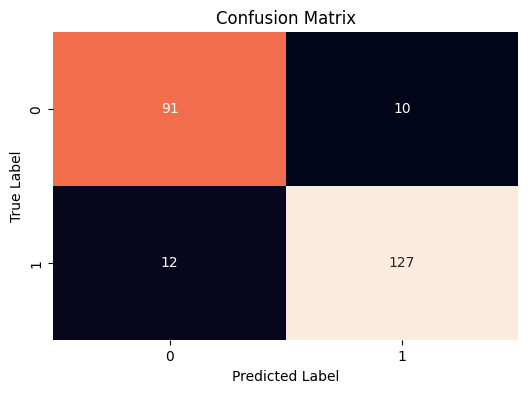

In [68]:
lr_cm = metrics.confusion_matrix(y_val, y_pred_lr)
conf_mat(lr_cm)

In [69]:
# testing
ylr_test_pred = lr_model.predict(x_test)
class_rep(y_test, ylr_test_pred)

              precision    recall  f1-score     support
0              0.945055  0.934783  0.939891   92.000000
1              0.945946  0.954545  0.950226  110.000000
accuracy       0.945545  0.945545  0.945545    0.945545
macro avg      0.945500  0.944664  0.945058  202.000000
weighted avg   0.945540  0.945545  0.945519  202.000000


In [70]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, ylr_test_pred)

Accuracy: 0.9455445544554455
Precision: 0.9459459459459459
Recall: 0.9545454545454546
f1-score: 0.9502262443438914
NPV: 0.945054945054945
Specificity: 0.9347826086956522


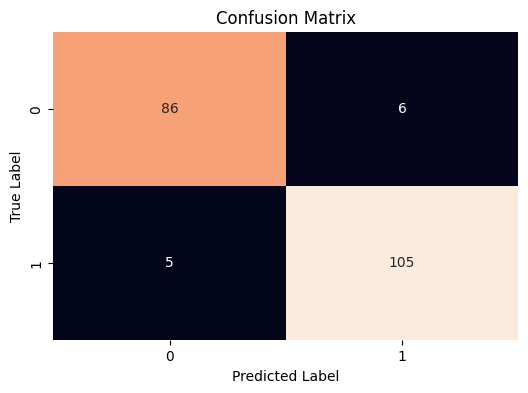

In [71]:
lr_cm_test = metrics.confusion_matrix(y_test, ylr_test_pred)
conf_mat(lr_cm_test)

In [72]:
model_Performance['Logistic Regression (Hyperparameter Tuning)']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['Logistic Regression (Hyperparameter Tuning)']

[0.9455445544554455,
 0.9459459459459459,
 0.9545454545454546,
 0.9502262443438914,
 np.float64(0.945054945054945),
 np.float64(0.9347826086956522)]

## Random Forest

In [73]:
rf_model = RandomForestClassifier(n_estimators=200,criterion='entropy', random_state=42)
start_time = time.perf_counter()
rf_model.fit(x_train, y_train)
model_trainTime['RF'] = time.perf_counter() - start_time
print(f"Training time: {model_trainTime['RF']:.4f} seconds")

y_pred_rf = rf_model.predict(x_val)

Training time: 0.9536 seconds


In [74]:
metrics_eval(y_val, y_pred_rf)

Accuracy: 0.9458333333333333
Precision: 0.9772727272727273
Recall: 0.9280575539568345
f1-score: 0.9520295202952029
NPV: 0.9074074074074074
Specificity: 0.9702970297029703


(0.9458333333333333,
 0.9772727272727273,
 0.9280575539568345,
 0.9520295202952029,
 np.float64(0.9074074074074074),
 np.float64(0.9702970297029703))

In [75]:
class_rep(y_val, y_pred_rf)

              precision    recall  f1-score     support
0              0.907407  0.970297  0.937799  101.000000
1              0.977273  0.928058  0.952030  139.000000
accuracy       0.945833  0.945833  0.945833    0.945833
macro avg      0.942340  0.949177  0.944914  240.000000
weighted avg   0.947871  0.945833  0.946041  240.000000


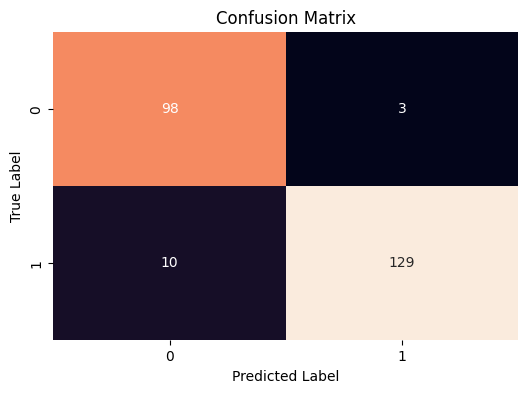

In [76]:
rf_cm = metrics.confusion_matrix(y_val, y_pred_rf)
conf_mat(rf_cm)

In [77]:
# testing
yrf_test_pred = rf_model.predict(x_test)
class_rep(y_test, yrf_test_pred)

              precision    recall  f1-score     support
0              0.900000  0.978261  0.937500   92.000000
1              0.980392  0.909091  0.943396  110.000000
accuracy       0.940594  0.940594  0.940594    0.940594
macro avg      0.940196  0.943676  0.940448  202.000000
weighted avg   0.943778  0.940594  0.940711  202.000000


In [78]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, yrf_test_pred)

Accuracy: 0.9405940594059405
Precision: 0.9803921568627451
Recall: 0.9090909090909091
f1-score: 0.9433962264150944
NPV: 0.9
Specificity: 0.9782608695652174


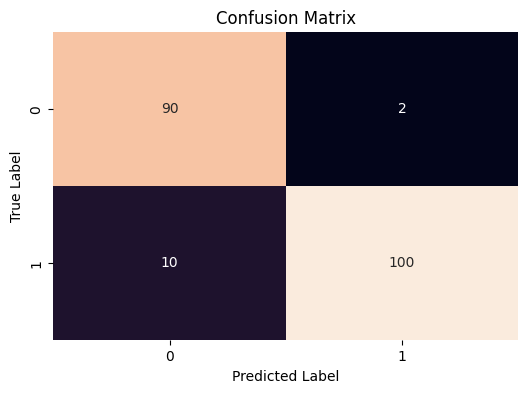

In [79]:
rf_cm_test = metrics.confusion_matrix(y_test, yrf_test_pred)
conf_mat(rf_cm_test)

In [80]:
model_Performance['Random Forest']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['Random Forest']

[0.9405940594059405,
 0.9803921568627451,
 0.9090909090909091,
 0.9433962264150944,
 np.float64(0.9),
 np.float64(0.9782608695652174)]

## Random Forest (Adjust Parameter)

In [81]:
pg = {'n_estimators': [20, 50, 75, 100, 150, 175, 180, 190, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50, 60]}

rf_model = RandomForestClassifier(random_state=42)
start_time = time.perf_counter()
gs = GridSearchCV(rf_model, pg, cv=5)
gs.fit(x_train, y_train)

print("Best n estimators:", gs.best_params_['n_estimators'])
print("Best max depth:", gs.best_params_['max_depth'])

rf_model = RandomForestClassifier(random_state=42, max_depth = gs.best_params_['max_depth'], n_estimators = gs.best_params_['n_estimators'])
rf_model.fit(x_train, y_train)
model_ht_trainTime['RF'] = time.perf_counter() - start_time
print(f"Training time: {model_ht_trainTime['RF']:.4f} seconds")

y_pred_rf = rf_model.predict(x_val)

Best n estimators: 200
Best max depth: 20
Training time: 179.3508 seconds


In [82]:
metrics_eval(y_val, y_pred_rf)

Accuracy: 0.9291666666666667
Precision: 0.9552238805970149
Recall: 0.920863309352518
f1-score: 0.9377289377289377
NPV: 0.8962264150943396
Specificity: 0.9405940594059405


(0.9291666666666667,
 0.9552238805970149,
 0.920863309352518,
 0.9377289377289377,
 np.float64(0.8962264150943396),
 np.float64(0.9405940594059405))

In [83]:
class_rep(y_val, y_pred_rf)

              precision    recall  f1-score     support
0              0.896226  0.940594  0.917874  101.000000
1              0.955224  0.920863  0.937729  139.000000
accuracy       0.929167  0.929167  0.929167    0.929167
macro avg      0.925725  0.930729  0.927802  240.000000
weighted avg   0.930396  0.929167  0.929373  240.000000


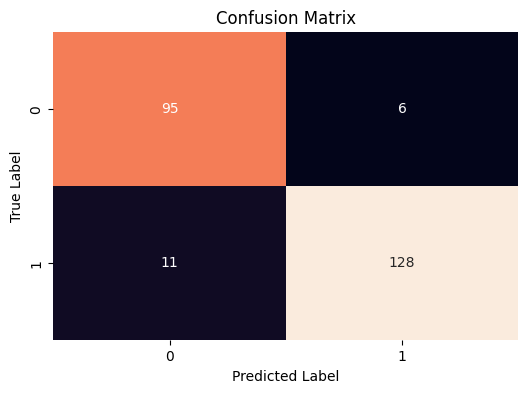

In [84]:
rf_cm = metrics.confusion_matrix(y_val, y_pred_rf)
conf_mat(rf_cm)

In [85]:
# testing
yrf_test_pred = rf_model.predict(x_test)
class_rep(y_test, yrf_test_pred)

              precision    recall  f1-score     support
0              0.923913  0.923913  0.923913   92.000000
1              0.936364  0.936364  0.936364  110.000000
accuracy       0.930693  0.930693  0.930693    0.930693
macro avg      0.930138  0.930138  0.930138  202.000000
weighted avg   0.930693  0.930693  0.930693  202.000000


In [86]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, yrf_test_pred)

Accuracy: 0.9306930693069307
Precision: 0.9363636363636364
Recall: 0.9363636363636364
f1-score: 0.9363636363636364
NPV: 0.9239130434782609
Specificity: 0.9239130434782609


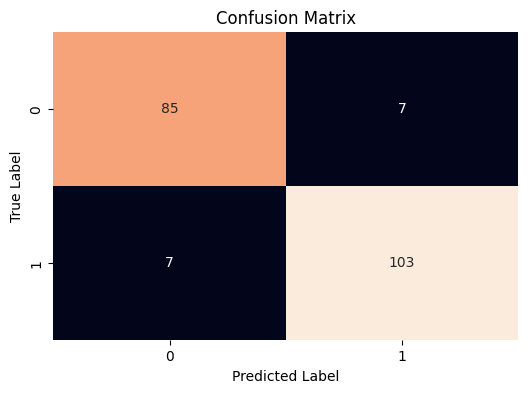

In [87]:
rf_cm_test = metrics.confusion_matrix(y_test, yrf_test_pred)
conf_mat(rf_cm_test)

In [88]:
model_Performance['Random Forest (Hyperparameter Tuning)']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['Random Forest (Hyperparameter Tuning)']

[0.9306930693069307,
 0.9363636363636364,
 0.9363636363636364,
 0.9363636363636364,
 np.float64(0.9239130434782609),
 np.float64(0.9239130434782609)]

## Support Vector Classifier

In [89]:
svc_model = SVC(random_state=42)
start_time = time.perf_counter()
svc_model.fit(x_train, y_train)
model_trainTime['SVC'] = time.perf_counter() - start_time
y_pred_svc = svc_model.predict(x_val)

print(f"Training time: {model_trainTime['SVC']:.4f} seconds")

Training time: 0.0538 seconds


In [90]:
metrics_eval(y_val, y_pred_svc)

Accuracy: 0.8541666666666666
Precision: 0.8333333333333334
Recall: 0.935251798561151
f1-score: 0.8813559322033898
NPV: 0.8928571428571429
Specificity: 0.7425742574257426


(0.8541666666666666,
 0.8333333333333334,
 0.935251798561151,
 0.8813559322033898,
 np.float64(0.8928571428571429),
 np.float64(0.7425742574257426))

In [91]:
class_rep(y_val, y_pred_svc)

              precision    recall  f1-score     support
0              0.892857  0.742574  0.810811  101.000000
1              0.833333  0.935252  0.881356  139.000000
accuracy       0.854167  0.854167  0.854167    0.854167
macro avg      0.863095  0.838913  0.846083  240.000000
weighted avg   0.858383  0.854167  0.851668  240.000000


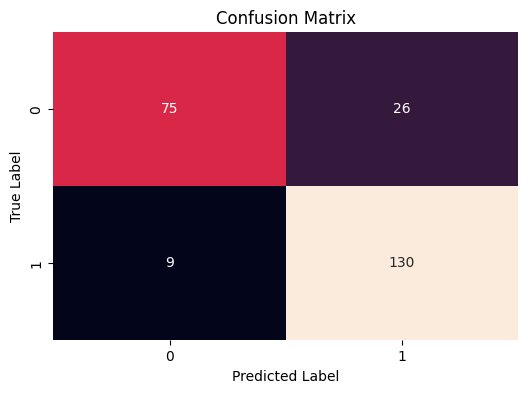

In [92]:
svc_cm = metrics.confusion_matrix(y_val, y_pred_svc)
conf_mat(svc_cm)

In [93]:
# testing
ysvc_test_pred = svc_model.predict(x_test)
class_rep(y_test, ysvc_test_pred)

              precision    recall  f1-score     support
0              0.936709  0.804348  0.865497   92.000000
1              0.853659  0.954545  0.901288  110.000000
accuracy       0.886139  0.886139  0.886139    0.886139
macro avg      0.895184  0.879447  0.883392  202.000000
weighted avg   0.891483  0.886139  0.884987  202.000000


In [94]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, ysvc_test_pred)

Accuracy: 0.8861386138613861
Precision: 0.8536585365853658
Recall: 0.9545454545454546
f1-score: 0.9012875536480687
NPV: 0.9367088607594937
Specificity: 0.8043478260869565


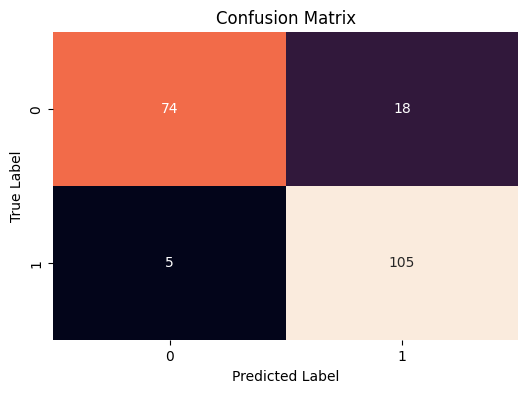

In [95]:
svc_cm_test = metrics.confusion_matrix(y_test, ysvc_test_pred)
conf_mat(svc_cm_test)

In [96]:
model_Performance['SVC']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['SVC']

[0.8861386138613861,
 0.8536585365853658,
 0.9545454545454546,
 0.9012875536480687,
 np.float64(0.9367088607594937),
 np.float64(0.8043478260869565)]

## Support Vector Classifier (Adjust Parameter)

In [97]:
pg= {'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10]}
svc_model = SVC(random_state=42)
start_time = time.perf_counter()
gs = GridSearchCV(svc_model, pg, cv=5)
gs.fit(x_train, y_train)

print("Best gamma:", gs.best_params_['gamma'])
print("Best C:", gs.best_params_['C'])

svc_model = SVC(random_state=42, gamma=gs.best_params_['gamma'], C=gs.best_params_['C'])
svc_model.fit(x_train, y_train)

model_ht_trainTime['SVC'] = time.perf_counter() - start_time
print(f"Training time: {model_ht_trainTime['SVC']:.4f} seconds")

y_pred_svc = svc_model.predict(x_val)

Best gamma: 0.1
Best C: 10
Training time: 2.0976 seconds


In [98]:
metrics_eval(y_val, y_pred_svc)

Accuracy: 0.9208333333333333
Precision: 0.9411764705882353
Recall: 0.920863309352518
f1-score: 0.9309090909090909
NPV: 0.8942307692307693
Specificity: 0.9207920792079208


(0.9208333333333333,
 0.9411764705882353,
 0.920863309352518,
 0.9309090909090909,
 np.float64(0.8942307692307693),
 np.float64(0.9207920792079208))

In [99]:
class_rep(y_val, y_pred_svc)

              precision    recall  f1-score     support
0              0.894231  0.920792  0.907317  101.000000
1              0.941176  0.920863  0.930909  139.000000
accuracy       0.920833  0.920833  0.920833    0.920833
macro avg      0.917704  0.920828  0.919113  240.000000
weighted avg   0.921420  0.920833  0.920981  240.000000


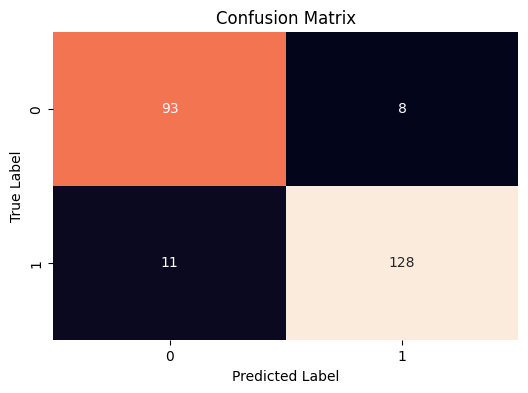

In [100]:
svc_cm = metrics.confusion_matrix(y_val, y_pred_svc)
conf_mat(svc_cm)

In [101]:
# testing
ysvc_test_pred = svc_model.predict(x_test)
class_rep(y_test, ysvc_test_pred)

              precision    recall  f1-score     support
0              0.925532  0.945652  0.935484   92.000000
1              0.953704  0.936364  0.944954  110.000000
accuracy       0.940594  0.940594  0.940594    0.940594
macro avg      0.939618  0.941008  0.940219  202.000000
weighted avg   0.940873  0.940594  0.940641  202.000000


In [102]:
acc, prec, rec, f1Score, NPV, specificity = metrics_eval(y_test, ysvc_test_pred)

Accuracy: 0.9405940594059405
Precision: 0.9537037037037037
Recall: 0.9363636363636364
f1-score: 0.944954128440367
NPV: 0.925531914893617
Specificity: 0.9456521739130435


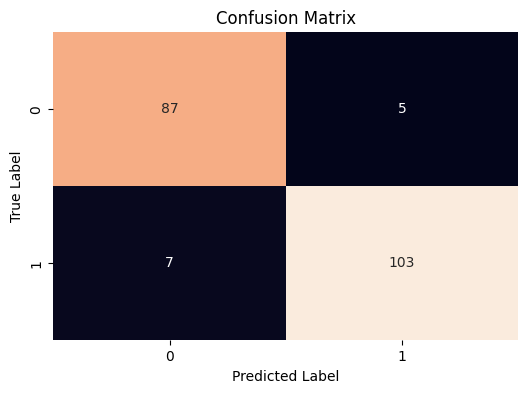

In [103]:
svc_cm_test = metrics.confusion_matrix(y_test, ysvc_test_pred)
conf_mat(svc_cm_test)

In [104]:
model_Performance['SVC (Hyperparameter Tuning)']= [acc, prec, rec, f1Score, NPV, specificity]
model_Performance['SVC (Hyperparameter Tuning)']

[0.9405940594059405,
 0.9537037037037037,
 0.9363636363636364,
 0.944954128440367,
 np.float64(0.925531914893617),
 np.float64(0.9456521739130435)]

## All Results

In [105]:
print(model_trainTime)

{'Naive_Bayes': 0.009221943999989435, 'LR': 0.031436343999985183, 'RF': 0.9536348269999735, 'SVC': 0.05379787800001168}


In [106]:
time1 = pd.DataFrame(model_trainTime, index=['Time']).transpose().reset_index()
time1.to_csv('time1.csv', index=False)
time1

,index,Time
0,Naive_Bayes,0.009222
1,LR,0.031436
2,RF,0.953635
3,SVC,0.053798


In [107]:
print(model_ht_trainTime)

{'Naive_Bayes': 0.6091969460000257, 'LR': 0.48102077300001156, 'RF': 179.35080307899997, 'SVC': 2.0975668739999946}


In [108]:
time2 = pd.DataFrame(model_ht_trainTime, index=['Time']).transpose().reset_index()
time2.to_csv('time2.csv', index=False)
time2

,index,Time
0,Naive_Bayes,0.609197
1,LR,0.481021
2,RF,179.350803
3,SVC,2.097567


In [109]:
result = pd.DataFrame(model_Performance, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'NPV', 'Specificity'])
result = result.transpose().reset_index()
result

,index,Accuracy,Precision,Recall,F1-Score,NPV,Specificity
0,Naive Bayes,0.772277,0.705128,1.000000,0.827068,1.000000,0.500000
1,Naive Bayes (Hyperparameter Tuning),0.861386,0.810606,0.972727,0.884298,0.957143,0.728261
2,Logistic Regression,0.900990,0.857143,0.981818,0.915254,0.973684,0.804348
3,Logistic Regression (Hyperparameter Tuning),0.945545,0.945946,0.954545,0.950226,0.945055,0.934783
4,Random Forest,0.940594,0.980392,0.909091,0.943396,0.900000,0.978261
5,Random Forest (Hyperparameter Tuning),0.930693,0.936364,0.936364,0.936364,0.923913,0.923913
6,SVC,0.886139,0.853659,0.954545,0.901288,0.936709,0.804348
7,SVC (Hyperparameter Tuning),0.940594,0.953704,0.936364,0.944954,0.925532,0.945652


In [110]:
result.to_csv('model_performance.csv', index=False)